In [5]:
import pandas as pd
import numpy as np
import gzip
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder

# from ann_visualizer.visualize import ann_viz    

from keras.models import Sequential
from keras.utils import plot_model
from keras.layers import Dense
from keras.optimizers import Adam

#### <font style  = "font-family : IBM plex mono" id = "importing-dataset">**Importing the dataset**</font>

In [2]:
df = pd.read_csv('kddcup.data_10_percent.gz', header=None)
cols = pd.read_csv('kddcup.names',header=None)

df.head()

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


In [3]:
with open('training_attack_types', 'r') as f:
    attack_types = f.read()
    print(attack_types)

back dos
buffer_overflow u2r
ftp_write r2l
guess_passwd r2l
imap r2l
ipsweep probe
land dos
loadmodule u2r
multihop r2l
neptune dos
nmap probe
perl u2r
phf r2l
pod dos
portsweep probe
rootkit u2r
satan probe
smurf dos
spy r2l
teardrop dos
warezclient r2l
warezmaster r2l




In [4]:
## Creating a dictionary of attack types
types = dict()
types['normal'] = 'normal'
for line in attack_types.split("\n"):
    if line:
        attack, description = line.split(" ", 1)
        types[attack] = description

print(types)

{'normal': 'normal', 'back': 'dos', 'buffer_overflow': 'u2r', 'ftp_write': 'r2l', 'guess_passwd': 'r2l', 'imap': 'r2l', 'ipsweep': 'probe', 'land': 'dos', 'loadmodule': 'u2r', 'multihop': 'r2l', 'neptune': 'dos', 'nmap': 'probe', 'perl': 'u2r', 'phf': 'r2l', 'pod': 'dos', 'portsweep': 'probe', 'rootkit': 'u2r', 'satan': 'probe', 'smurf': 'dos', 'spy': 'r2l', 'teardrop': 'dos', 'warezclient': 'r2l', 'warezmaster': 'r2l'}


In [5]:
if cols[0][0] == 'back':
    cols = cols.drop(cols.index[0])
    cols.reset_index(drop=True, inplace=True)

cols = cols.dropna(axis=1)
cols.head()

,0
0,duration: continuous.
1,protocol_type: symbolic.
2,service: symbolic.
3,flag: symbolic.
4,src_bytes: continuous.


In [6]:
cols[[0,1]] = cols[0].str.split(':',expand = True)

cols.head()

,0,1
0,duration,continuous.
1,protocol_type,symbolic.
2,service,symbolic.
3,flag,symbolic.
4,src_bytes,continuous.


In [7]:
names = cols[0].tolist()
names.append('label')
df.columns = names

In [8]:
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


In [9]:
df['Attack Type'] = df['label'].apply(lambda x: types[x[:-1]])
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,Attack Type
0,0,tcp,http,SF,181,5450,0,0,0,0,...,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.,normal
1,0,tcp,http,SF,239,486,0,0,0,0,...,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.,normal
2,0,tcp,http,SF,235,1337,0,0,0,0,...,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.,normal
3,0,tcp,http,SF,219,1337,0,0,0,0,...,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.,normal
4,0,tcp,http,SF,217,2032,0,0,0,0,...,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.,normal


#### <font style  = "font-family : IBM plex mono" id = "exploratory-data-analysis">**Exploratory Data Analysis**</font>

In [10]:
AT_count = df['Attack Type'].value_counts()
AT_count

Attack Type
dos       391458
normal     97278
probe       4107
r2l         1126
u2r           52
Name: count, dtype: int64

In [11]:
AT_per = AT_count/len(df)*100
AT_per

Attack Type
dos       79.239142
normal    19.691066
probe      0.831341
r2l        0.227926
u2r        0.010526
Name: count, dtype: float64

In [12]:
lab_count = df.label.value_counts()
lab_count

label
smurf.              280790
neptune.            107201
normal.              97278
back.                 2203
satan.                1589
ipsweep.              1247
portsweep.            1040
warezclient.          1020
teardrop.              979
pod.                   264
nmap.                  231
guess_passwd.           53
buffer_overflow.        30
land.                   21
warezmaster.            20
imap.                   12
rootkit.                10
loadmodule.              9
ftp_write.               8
multihop.                7
phf.                     4
perl.                    3
spy.                     2
Name: count, dtype: int64

In [13]:
lab_per = lab_count/len(df)*100
lab_per

label
smurf.              56.837665
neptune.            21.699685
normal.             19.691066
back.                0.445932
satan.               0.321646
ipsweep.             0.252418
portsweep.           0.210517
warezclient.         0.206469
teardrop.            0.198170
pod.                 0.053439
nmap.                0.046759
guess_passwd.        0.010728
buffer_overflow.     0.006073
land.                0.004251
warezmaster.         0.004048
imap.                0.002429
rootkit.             0.002024
loadmodule.          0.001822
ftp_write.           0.001619
multihop.            0.001417
phf.                 0.000810
perl.                0.000607
spy.                 0.000405
Name: count, dtype: float64

In [14]:
print("Shape :",df.shape)
print("Number of features :",len(df.columns))
print("Number of unique services :",df.service.nunique())
print("Number of labels :",len(df['label'].unique()))
print("missing values :",df.isnull().sum().sum())

Shape : (494021, 43)
Number of features : 43
Number of unique services : 66
Number of labels : 23
missing values : 0


In [15]:
df.isna().sum().sum()

0

In [16]:
categorical = df.select_dtypes(include=['object']).columns
print("Categorical features :",categorical)
categorical = categorical.tolist()
print("Categorical features list:",categorical)
categorical.remove('label')
categorical.remove('Attack Type')
print("Extracted categorical features list:",categorical)

Categorical features : Index(['protocol_type', 'service', 'flag', 'label', 'Attack Type'], dtype='object')
Categorical features list: ['protocol_type', 'service', 'flag', 'label', 'Attack Type']
Extracted categorical features list: ['protocol_type', 'service', 'flag']


C:\Users\anany\AppData\Local\Temp\ipykernel_12176\2692194056.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='protocol_type', data=df, ax=ax, palette='Blues_d')


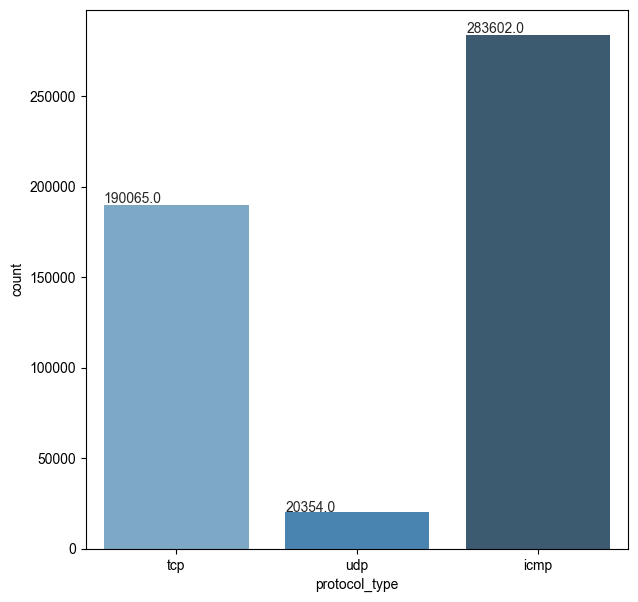

In [17]:
fig, ax = plt.subplots(figsize=(7, 7))
sns.countplot(x='protocol_type', data=df, ax=ax, palette='Blues_d')
sns.set_style("darkgrid")

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

In [18]:
df.protocol_type.value_counts()/len(df)*100

protocol_type
icmp    57.406871
tcp     38.473061
udp      4.120068
Name: count, dtype: float64

C:\Users\anany\AppData\Local\Temp\ipykernel_12176\227120374.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='service', data=df, ax=ax, palette='Spectral', order=df['service'].value_counts().index,linewidth=0)


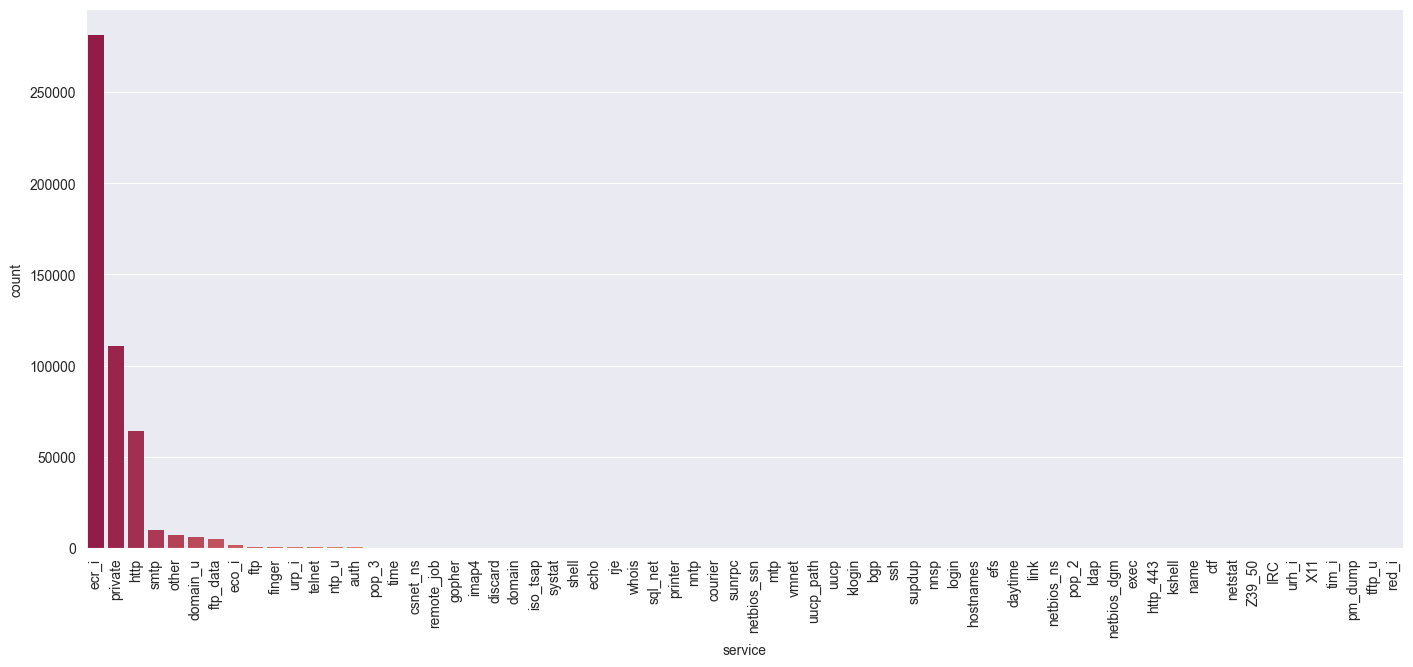

In [19]:
fig, ax = plt.subplots(figsize=(17, 7))
sns.countplot(x='service', data=df, ax=ax, palette='Spectral', order=df['service'].value_counts().index,linewidth=0)
sns.set_style("dark")
plt.xticks(rotation=90)
plt.show()

In [20]:
df.service.value_counts()/len(df)*100

service
ecr_i      56.961141
private    22.447021
http       13.014224
smtp        1.968135
other       1.464917
             ...    
X11         0.002227
tim_i       0.001417
pm_dump     0.000202
tftp_u      0.000202
red_i       0.000202
Name: count, Length: 66, dtype: float64

C:\Users\anany\AppData\Local\Temp\ipykernel_12176\785337491.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='flag', data=df, ax=ax, palette='Blues_r', order=df['flag'].value_counts().index,linewidth=0)


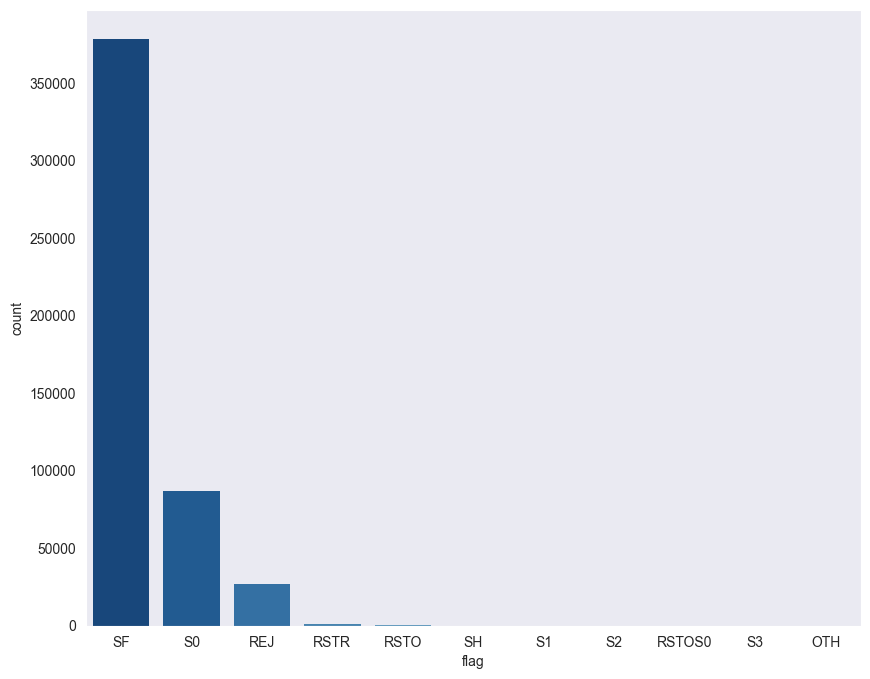

In [21]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.countplot(x='flag', data=df, ax=ax, palette='Blues_r', order=df['flag'].value_counts().index,linewidth=0)
plt.show()

In [22]:
df.flag.value_counts()/len(df)*100

flag
SF        76.604031
S0        17.612004
REJ        5.440052
RSTR       0.182786
RSTO       0.117201
SH         0.021659
S1         0.011538
S2         0.004858
RSTOS0     0.002227
S3         0.002024
OTH        0.001619
Name: count, dtype: float64

In [23]:
# sum of all the attack types except SF, S0 and REJ
(df['Attack Type'].value_counts().sum() - df['Attack Type'].value_counts()[0] - df['Attack Type'].value_counts()[1] - df['Attack Type'].value_counts()[2])/(df['Attack Type'].value_counts().sum())*100

C:\Users\anany\AppData\Local\Temp\ipykernel_12176\1677951948.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  (df['Attack Type'].value_counts().sum() - df['Attack Type'].value_counts()[0] - df['Attack Type'].value_counts()[1] - df['Attack Type'].value_counts()[2])/(df['Attack Type'].value_counts().sum())*100
C:\Users\anany\AppData\Local\Temp\ipykernel_12176\1677951948.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  (df['Attack Type'].value_counts().sum() - df['Attack Type'].value_counts()[0] - df['Attack Type'].value_counts()[1] - df['Attack Type'].value_counts()[2])/(df['Attack Type'].value_counts().sum())*10

0.23845140186348354

C:\Users\anany\AppData\Local\Temp\ipykernel_12176\3282189032.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Attack Type', data=df, ax=ax, palette='Greens_r', order=df['Attack Type'].value_counts().index,linewidth=0)


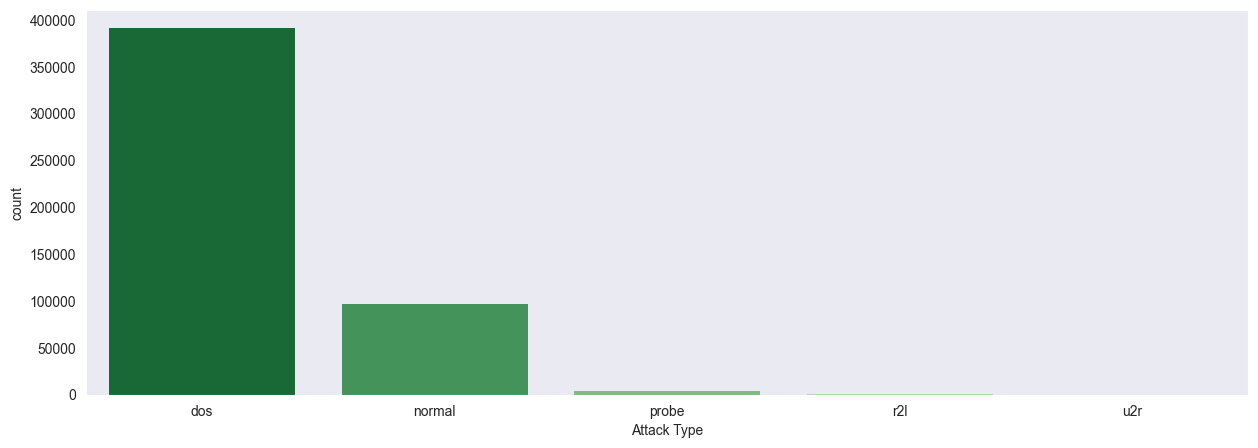

Top 3 the attack types are :  ['dos', 'normal', 'probe']


In [24]:
fig, ax = plt.subplots(figsize=(15,5))
sns.countplot(x='Attack Type', data=df, ax=ax, palette='Greens_r', order=df['Attack Type'].value_counts().index,linewidth=0)
plt.show()
print('Top 3 the attack types are : ',df['Attack Type'].value_counts().index[:3].tolist())

### <font style  = "font-family : IBM plex mono" id = "data-preprocessing">**Data Preproceesing**</font>

we can see that there are no missing values in the dataset


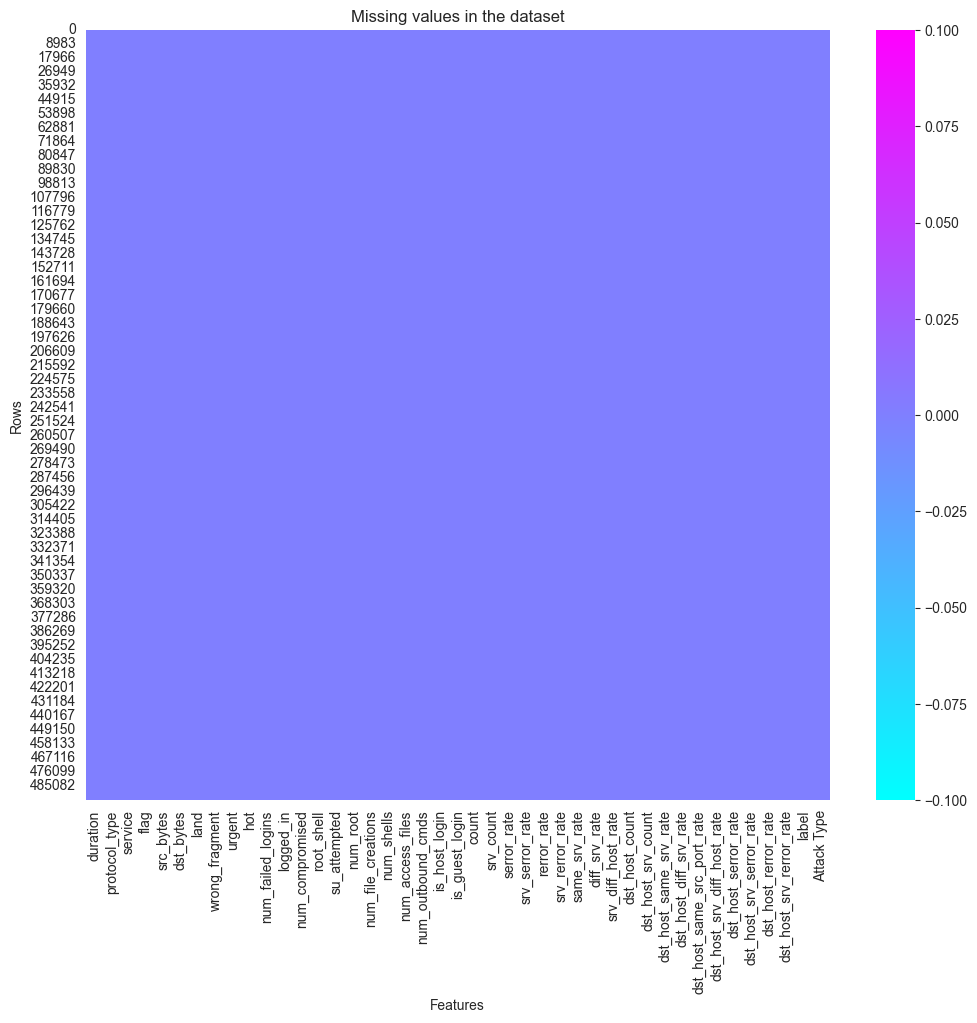

In [25]:
fig,axis = plt.subplots(figsize=(12,10))
sns.heatmap(df.isnull(), cmap='cool')
print("we can see that there are no missing values in the dataset")
plt.title("Missing values in the dataset")
axis.set_xlabel("Features")
axis.set_ylabel("Rows")
plt.show()

(494021, 141)


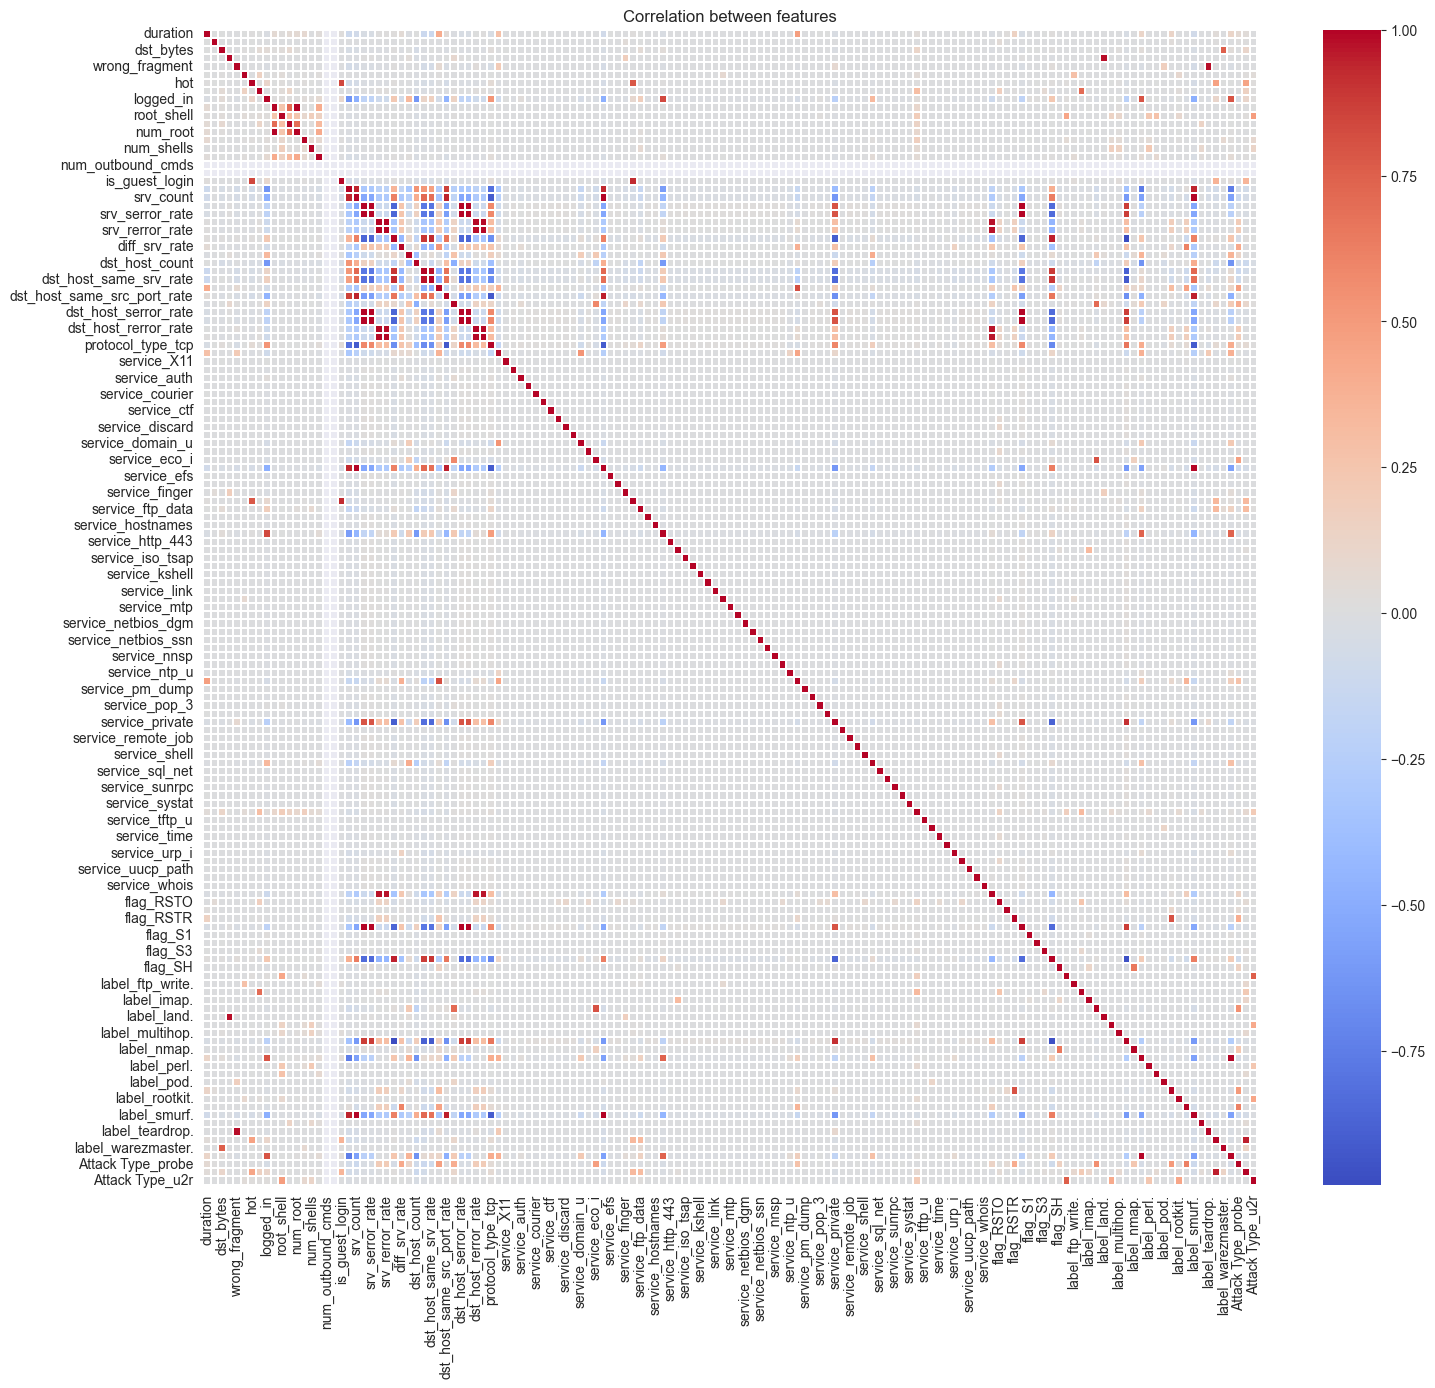

In [26]:
df1 = pd.get_dummies(df, drop_first=True)  # One-hot encode non-numeric columns
corr = df1.corr()
print(df1.shape)
fig, ax = plt.subplots(figsize=(17, 15))
sns.heatmap(corr, cmap='coolwarm', ax=ax, linewidths=0.1)
plt.title("Correlation between features")
plt.show()

In [27]:
high_corr = corr[abs(corr) > 0.8] # type: ignore

high_corr_pairs = high_corr.unstack().sort_values(kind="quicksort", ascending=False).drop_duplicates()

high_corr_pairs

duration                     duration                    1.000000
srv_serror_rate              dst_host_srv_serror_rate    0.999304
serror_rate                  dst_host_serror_rate        0.998673
flag_S0                      srv_serror_rate             0.998648
dst_host_srv_serror_rate     flag_S0                     0.998588
                                                           ...   
dst_host_same_srv_rate       label_neptune.             -0.910480
dst_host_same_src_port_rate  protocol_type_tcp          -0.919562
label_neptune.               flag_SF                    -0.952577
                             same_srv_rate              -0.979739
duration                     src_bytes                        NaN
Length: 78, dtype: float64

In [28]:
df.drop('num_root', axis=1, inplace=True)
df.drop('srv_rerror_rate', axis=1, inplace=True)
df.drop('dst_host_srv_rerror_rate', axis=1, inplace=True)
df.drop('dst_host_rerror_rate', axis=1, inplace=True)
df.drop('srv_serror_rate', axis=1, inplace=True)
df.drop('dst_host_srv_serror_rate', axis=1, inplace=True)
df.drop('dst_host_serror_rate', axis=1, inplace=True)
df.drop('dst_host_same_srv_rate', axis=1, inplace=True)

In [29]:
df.shape

(494021, 35)

In [30]:
df.dtypes

duration                         int64
protocol_type                   object
service                         object
flag                            object
src_bytes                        int64
dst_bytes                        int64
land                             int64
wrong_fragment                   int64
urgent                           int64
hot                              int64
num_failed_logins                int64
logged_in                        int64
num_compromised                  int64
root_shell                       int64
su_attempted                     int64
num_file_creations               int64
num_shells                       int64
num_access_files                 int64
num_outbound_cmds                int64
is_host_login                    int64
is_guest_login                   int64
count                            int64
srv_count                        int64
serror_rate                    float64
rerror_rate                    float64
same_srv_rate            

In [31]:
print(df.columns)


Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_file_creations', 'num_shells', 'num_access_files',
       'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count',
       'srv_count', 'serror_rate', 'rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_diff_srv_rate',
       'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'label',
       'Attack Type'],
      dtype='object')


In [32]:
df['protocol_type'].value_counts()

protocol_type
icmp    283602
tcp     190065
udp      20354
Name: count, dtype: int64

In [33]:
df['service'].value_counts()

service
ecr_i      281400
private    110893
http        64293
smtp         9723
other        7237
            ...  
X11            11
tim_i           7
pm_dump         1
tftp_u          1
red_i           1
Name: count, Length: 66, dtype: int64

In [34]:
df['flag'].value_counts()

flag
SF        378440
S0         87007
REJ        26875
RSTR         903
RSTO         579
SH           107
S1            57
S2            24
RSTOS0        11
S3            10
OTH            8
Name: count, dtype: int64

#### <font style  = "font-family : IBM plex mono" id = "LabEn">**Label Encoding**</font>

In [35]:
Le = LabelEncoder()
df['protocol_type'] = Le.fit_transform(df['protocol_type'])
df['service'] = Le.fit_transform(df['service'])
df['flag'] = Le.fit_transform(df['flag'])

In [36]:
df['protocol_type'].value_counts()

protocol_type
0    283602
1    190065
2     20354
Name: count, dtype: int64

In [37]:
df['service'].value_counts()

service
14    281400
45    110893
22     64293
50      9723
40      7237
       ...  
1         11
58         7
41         1
57         1
46         1
Name: count, Length: 66, dtype: int64

<font style = "font-family : montserrat ; font-weight : 300 ; font-size : 15px">The <b><i>Service</i></b> feature has <u>66 unique values</u>, and some network services have very few connections associated with them, which would result in sparse features with little predictive power. Thus we drop this feature.<font>

In [38]:
df = df.drop(['service'], axis=1)

In [39]:
df['flag'].value_counts()

flag
9     378440
5      87007
1      26875
4        903
2        579
10       107
6         57
7         24
3         11
8         10
0          8
Name: count, dtype: int64

In [40]:
df.head()

,duration,protocol_type,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,...,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,label,Attack Type
0,0,1,9,181,5450,0,0,0,0,0,...,1.0,0.0,0.0,9,9,0.0,0.11,0.0,normal.,normal
1,0,1,9,239,486,0,0,0,0,0,...,1.0,0.0,0.0,19,19,0.0,0.05,0.0,normal.,normal
2,0,1,9,235,1337,0,0,0,0,0,...,1.0,0.0,0.0,29,29,0.0,0.03,0.0,normal.,normal
3,0,1,9,219,1337,0,0,0,0,0,...,1.0,0.0,0.0,39,39,0.0,0.03,0.0,normal.,normal
4,0,1,9,217,2032,0,0,0,0,0,...,1.0,0.0,0.0,49,49,0.0,0.02,0.0,normal.,normal


In [41]:
df.to_csv('processed_kdd.csv', index=False)

#### <font style  = "font-family : IBM plex mono" id = "fesca">**Feature Scaling**</font>

In [42]:
X = df.drop(['label', 'Attack Type'], axis=1)
y = df['Attack Type']

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

#### <font style  = "font-family : IBM plex mono" id = "tts">**Train - Test Split**</font>

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### <font style  = "font-family : IBM plex mono" id ="enc">**Target Encoding**</font>

In [44]:
y_train = np.array(y_train)
y_test = np.array(y_test)
encoder = OneHotEncoder()
y_train = encoder.fit_transform(y_train.reshape(-1, 1)).toarray()
y_test = encoder.fit_transform(y_test.reshape(-1, 1)).toarray()

#### <font style  = "font-family : IBM plex mono">**Hyperparameter Tuning**</font>

c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
12351/12351 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step - accuracy: 0.9844 - loss: 0.0571 - val_accuracy: 0.9848 - val_loss: 0.0471
Epoch 2/10
12351/12351 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step - accuracy: 0.9872 - loss: 0.0520 - val_accuracy: 0.9872 - val_loss: 0.0478
Epoch 3/10
12351/12351 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - accuracy: 0.9877 - loss: 0.0524 - val_accuracy: 0.9879 - val_loss: 0.0465
Epoch 4/10
12351/12351 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - accuracy: 0.9870 - loss: 0.0526 - val_accuracy: 0.9839 - val_loss: 0.0648
Epoch 5/10
12351/12351 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step - accuracy: 0.9884 - loss: 0.0597 - val_accuracy: 0.9907 - val_loss: 0.0429
Epoch 6/10
12351/12351 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step - accuracy: 0.9879 - loss: 0.0507 - val_accuracy: 0.9862 - val_loss: 0.0592
Epoch 7/10
12351/12351 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step - accuracy: 0.9874 - loss: 0.0541 - val_accuracy: 0.9842 - val_loss: 0.0702
Epoch 8/10
12351/12351 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step - accuracy: 

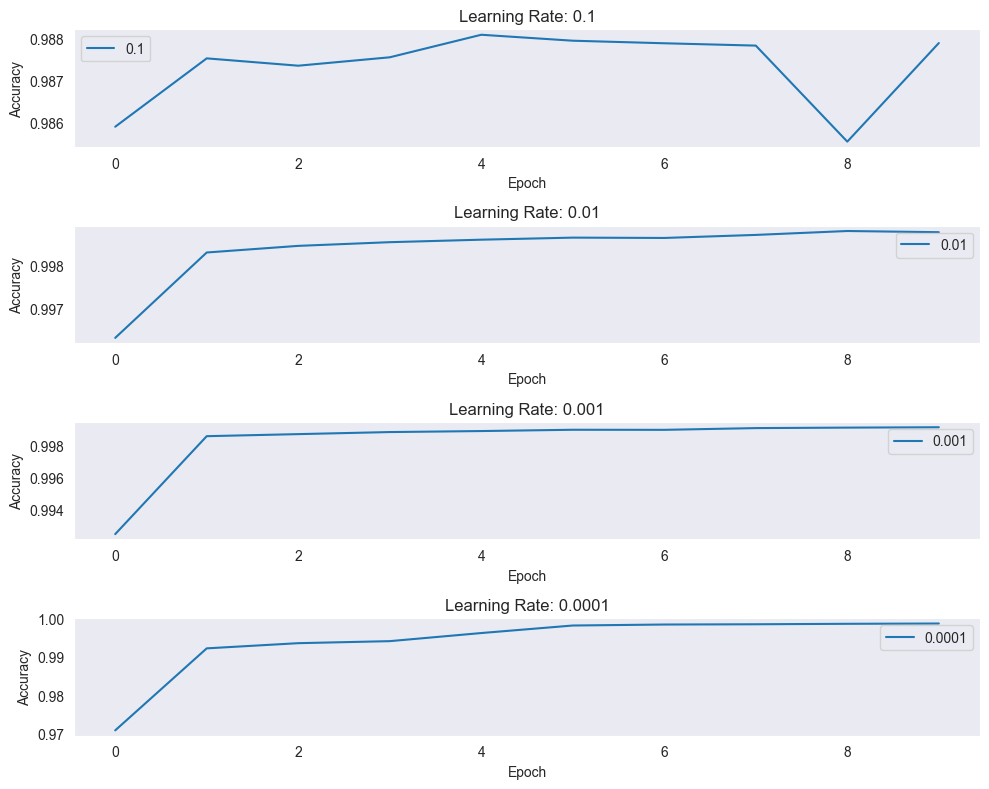

In [45]:
## checking how a model performs with different learning rates

fig, ax = plt.subplots(4,figsize=(10, 8))
ax = ax.flatten()

learning_rates = [0.1, 0.01, 0.001, 0.0001]
for i, lr in enumerate(learning_rates):
    opt = Adam(learning_rate=lr)
    model = Sequential()
    model.add(Dense(X_train.shape[1], input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(12, activation='relu'))
    model.add(Dense(5, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    trials = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

    ax[i].plot(trials.history['accuracy'], label= str(lr))
    ax[i].set_title('Learning Rate: ' + str(lr))
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel('Accuracy')
    ax[i].legend()

plt.tight_layout()
plt.show()

<font style = "font-family : montserrat ; font-weight : 200"><i>Thus we choose <b>0.001</b> as the best value for the regularization parameter.</i>

Epoch 1/10
12351/12351 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step - accuracy: 0.9633 - loss: 0.1380 - val_accuracy: 0.9969 - val_loss: 0.0114
Epoch 2/10
12351/12351 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - accuracy: 0.9979 - loss: 0.0087 - val_accuracy: 0.9983 - val_loss: 0.0068
Epoch 3/10
12351/12351 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - accuracy: 0.9984 - loss: 0.0061 - val_accuracy: 0.9983 - val_loss: 0.0069
Epoch 4/10
12351/12351 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - accuracy: 0.9986 - loss: 0.0054 - val_accuracy: 0.9987 - val_loss: 0.0055
Epoch 5/10
12351/12351 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step - accuracy: 0.9988 - loss: 0.0049 - val_accuracy: 0.9987 - val_loss: 0.0051
Epoch 6/10
12351/12351 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step - accuracy: 0.9989 - loss: 0.0046 - val_accuracy: 0.9988 - val_loss: 0.0048
Epoch 7/10
12351/12351 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step - accuracy: 0.9989 - loss: 0.0041 - val_accuracy: 0.9987 - val_loss: 0.0049
Epoch 8/10
12351/12351 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - accuracy: 

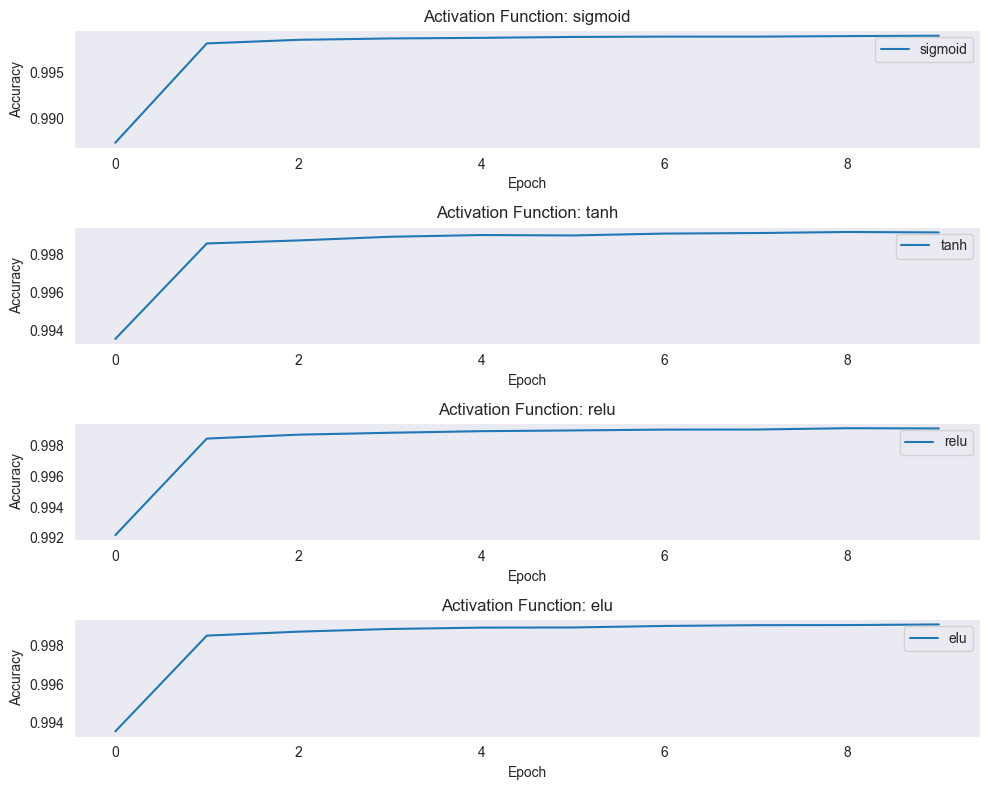

In [46]:
fig, ax = plt.subplots(4,figsize=(10, 8))
ax = ax.flatten()

activation_func = ['sigmoid', 'tanh', 'relu', 'elu']
for i, acfn in enumerate(activation_func):
    opt = Adam(learning_rate=0.001)
    model = Sequential()
    model.add(Dense(X_train.shape[1], input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(12, activation = acfn))
    model.add(Dense(5, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    trials = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

    ax[i].plot(trials.history['accuracy'], label= str(acfn))
    ax[i].set_title('Activation Function: ' + str(acfn))
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel('Accuracy')
    ax[i].legend()

plt.tight_layout()
plt.show()

### <font style  = "font-family : IBM plex mono">**Modelling a Neural Network**</font>

In [47]:
X_train.shape[1]

32

In [48]:
opt = Adam(learning_rate=0.001)
model = Sequential()
model.add(Dense(X_train.shape[1], input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(5, activation='softmax'))

In [49]:
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [50]:
trials = model.fit(X_train, y_train, epochs=10, validation_split=0.2, batch_size=64)

Epoch 1/10
4941/4941 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.9656 - loss: 0.1379 - val_accuracy: 0.9968 - val_loss: 0.0116
Epoch 2/10
4941/4941 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.9980 - loss: 0.0092 - val_accuracy: 0.9985 - val_loss: 0.0060
Epoch 3/10
4941/4941 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.9987 - loss: 0.0054 - val_accuracy: 0.9986 - val_loss: 0.0054
Epoch 4/10
4941/4941 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.9987 - loss: 0.0048 - val_accuracy: 0.9987 - val_loss: 0.0049
Epoch 5/10
4941/4941 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.9988 - loss: 0.0044 - val_accuracy: 0.9989 - val_loss: 0.0051
Epoch 6/10
4941/4941 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.9989 - loss: 0.0041 - val_accuracy: 0.9988 - val_loss: 0.0050
Epoch 7/10
4941/4941 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.9991 - loss: 0.0036 - val_accuracy: 0.9991 - val_loss: 0.0045
Epoch 8/10
4941/4941 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.9990 - loss: 0.0038 - 

In [51]:
plot_model(model, to_file='model_diagram.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [52]:
# ann_viz(model, title="Neural Network Model",view=True, filename="model.gv")

#### <font style  = "font-family : IBM plex mono">**Plotting History**</font>

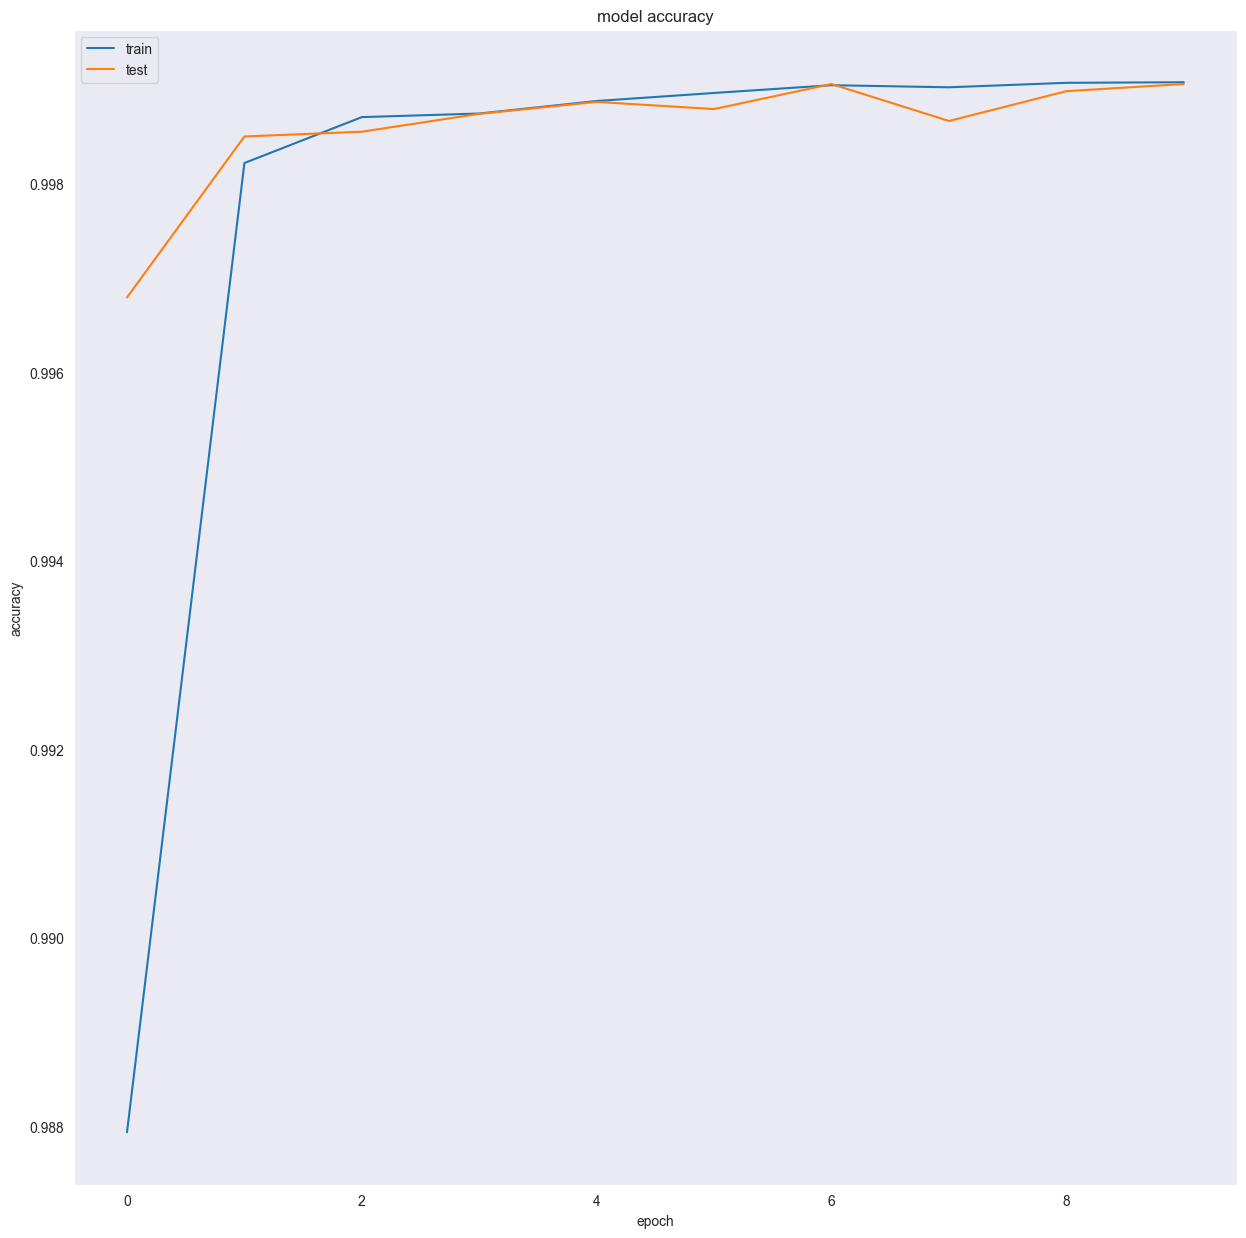

In [53]:
fig, ax = plt.subplots(figsize=(15, 15))
plt.plot(trials.history['accuracy'])
plt.plot(trials.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### <font style  = "font-family : IBM plex mono">**Model Evaluation**</font>

In [54]:
loss, accuracy = model.evaluate(X_test, y_test)
print(loss, accuracy)

3088/3088 ━━━━━━━━━━━━━━━━━━━━ 3s 920us/step - accuracy: 0.9988 - loss: 0.0039
0.004117210861295462 0.998836100101471


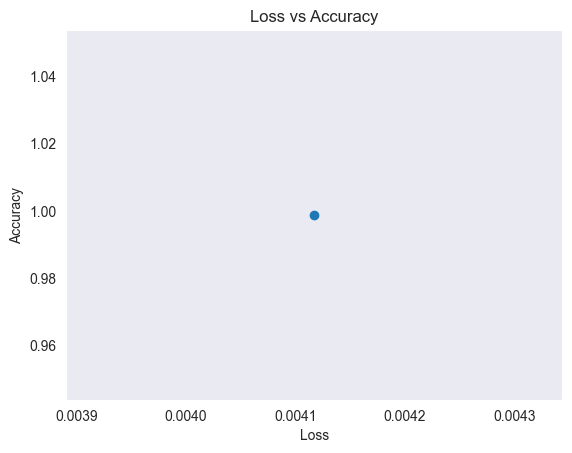

In [55]:
plt.scatter(loss, accuracy)
plt.title('Loss vs Accuracy')
plt.xlabel('Loss')
plt.ylabel('Accuracy')
plt.show()

<font style = "font-family : IBM plex mono ; color : #ffffff">We have a detailed anaysis of the model in the </font> 
[<font style = "font-family : IBM plex mono ; color : #ffffff"><u><i>evaluator file</i></u></font>](./evaluator.ipynb)

#### <font style  = "font-family : IBM plex mono">**Model Serialization**</font>

In [56]:
model.save('NN_model.h5')

In [58]:
model = tf.keras.models.load_model('NN_model.h5')

# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the converted model
with open('NN_model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\anany\AppData\Local\Temp\tmp5jq8ecof\assets


INFO:tensorflow:Assets written to: C:\Users\anany\AppData\Local\Temp\tmp5jq8ecof\assets


Saved artifact at 'C:\Users\anany\AppData\Local\Temp\tmp5jq8ecof'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 32), dtype=tf.float32, name='input_layer_8')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  1966389995920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1966063893200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1966389994192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1966389998608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1966063889168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1966063885136: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [1]:
# Python script to convert a .tflite model file to a C array format
def convert_to_c_array(filename):
    with open(filename, 'rb') as f:
        byte_data = f.read()

    c_array = ', '.join(f'0x{byte:02x}' for byte in byte_data)

    with open(f'{filename}.h', 'w') as f:
        f.write(f'const unsigned char NN_model[] = {{ {c_array} }};\n')
        f.write(f'const unsigned int NN_model_len = {len(byte_data)};\n')

# Usage
convert_to_c_array('NN_model.tflite')